# Download Daymet

In [1]:
%load_ext autoreload
%autoreload 2

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import logging
import numpy as np
import rasterio
import fiona
import os
import cftime, datetime

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_daymet
import watershed_workflow.daymet
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [4]:
watershed_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
crs = watershed_workflow.crs.daymet_crs()

## Load the Watershed

In [5]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile, out_crs=crs)
watershed_workflow.split_hucs.simplify(watershed, 60)

logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2024-05-06 22:17:50,045 - root - INFO: 
2024-05-06 22:17:50,050 - root - INFO: Loading shapes
2024-05-06 22:17:50,051 - root - INFO: ------------------------------
2024-05-06 22:17:50,051 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2024-05-06 22:17:50,071 - root - INFO: ... found 1 shapes
2024-05-06 22:17:50,071 - root - INFO: Converting to shapely
2024-05-06 22:17:50,072 - root - INFO:  ... done
2024-05-06 22:17:50,074 - root - INFO: Converting to requested CRS
2024-05-06 22:17:50,083 - root - INFO:  ... done
2024-05-06 22:17:50,084 - root - INFO: Removing holes on 1 polygons
2024-05-06 22:17:50,084 - root - INFO:   -- removed interior
2024-05-06 22:17:50,085 - root - INFO:   -- union
2024-05-06 22:17:50,085 - root - INFO: Parsing 1 components for holes
2024-05-06 22:17:50,086 - root - INFO:   -- complete
2024-05-06 22:17:50,087 - root - INFO: crs: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs


(1442135.5954880337, -650282.0481837074, 1447110.5975158159, -645090.2638397979)
4975.002027782146 5191.784343909472


## Download the raw DayMet raster

returned raw data has `dim(nband, ncol, nrow)`

In [6]:
startdate = "2000-1-1"
enddate = "2020-1-1"

In [7]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
met_data = source.get_data(bounds, crs, startdate, enddate)

2024-05-06 22:17:50,131 - root - INFO: Collecting DayMet file to tile bounds: [-83.4947, 35.0124, -83.4076, 35.0892]
2024-05-06 22:17:50,132 - root - INFO:   Using existing: /home/ecoon/code/watershed_workflow/data/meteorology/daymet/daymet_tmin_2000_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-06 22:17:50,132 - root - INFO: Collecting DayMet file to tile bounds: [-83.4947, 35.0124, -83.4076, 35.0892]
2024-05-06 22:17:50,133 - root - INFO:   Using existing: /home/ecoon/code/watershed_workflow/data/meteorology/daymet/daymet_tmin_2001_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-06 22:17:50,133 - root - INFO: Collecting DayMet file to tile bounds: [-83.4947, 35.0124, -83.4076, 35.0892]
2024-05-06 22:17:50,134 - root - INFO:   Using existing: /home/ecoon/code/watershed_workflow/data/meteorology/daymet/daymet_tmin_2002_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-06 22:17:50,134 - root - INFO: Collecting DayMet file to tile bounds: [-83.4947, 35.0124, -83.4076, 35.0892]
2024-05-06 22:17:50

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS. Note that typically we do **not** do this, and instead project the watershed into DayMet's CRS.  But we do it this way here to demonstrate how to do so.


In [8]:
print(type(met_data))

<class 'watershed_workflow.datasets.Dataset'>


In [9]:
met_data_warped = watershed_workflow.warp.dataset(met_data, dst_crs=crs)

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240429/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240429/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2024-05-06 22:17:50,832 - root - INFO: BOUNDS: (1439750.0, -652000.0, 1448750.0, -643000.0)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240429/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: Yo

Text(0.5, 1.0, 'Reprojected Daymet')

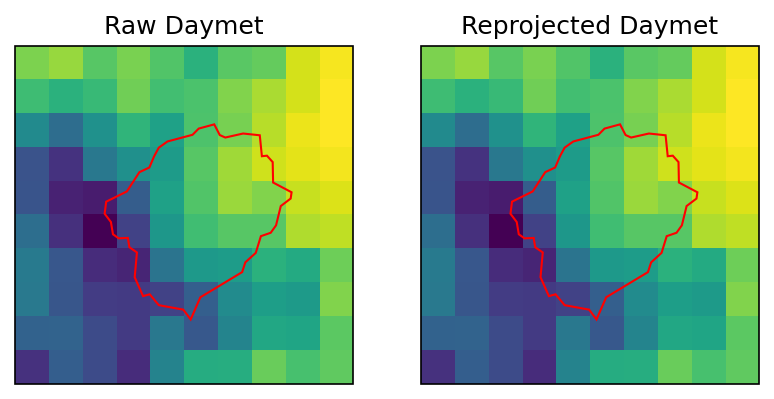

In [10]:
# Plot the original and reprojected datasets
ivar = 'tmax'
islice = 100
daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(daymet_crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
                                                     crs, daymet_crs)
watershed_workflow.plot.raster(met_data[ivar].profile, met_data[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(met_data_warped[ivar].profile, met_data_warped[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Reprojected Daymet")



## Save to Disk

### Write to HDF5

Write raw daymet data to a single HDF5 file.

In [11]:

filename = os.path.join('Coweeta','output_data', 'watershed_daymet-raw.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_warped, 
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))


2024-05-06 22:17:50,980 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-raw.h5


### Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [12]:
met_data_ats = watershed_workflow.daymet.convertToATS(met_data_warped)

filename = os.path.join('Coweeta', 'output_data', 'watershed_daymet-ats.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_ats,
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))
    

2024-05-06 22:17:56,134 - root - INFO: Converting to ATS met input
2024-05-06 22:17:56,193 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-ats.h5


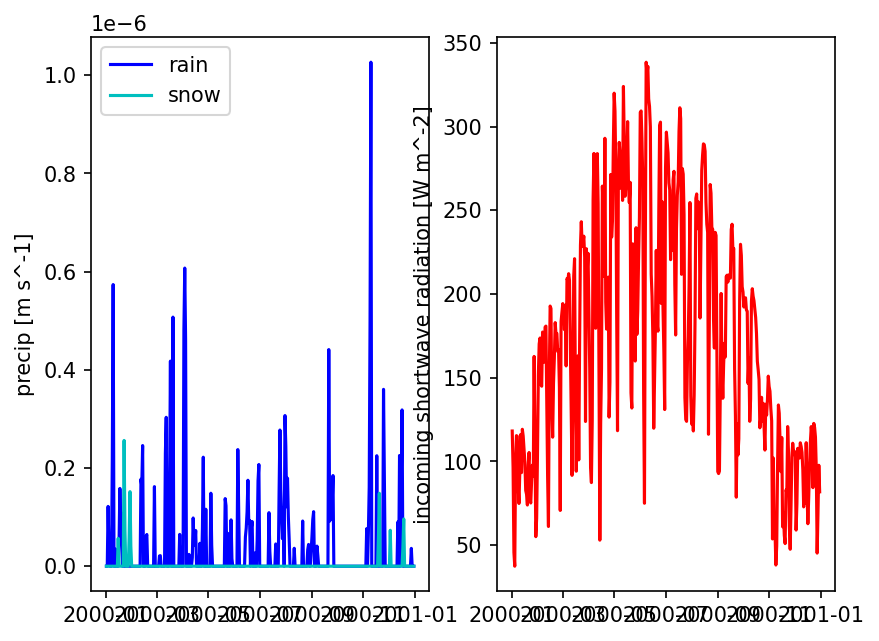

In [13]:
# plot one pixel as a function of time
fig = plt.figure()
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data_ats.times])
prain = met_data_ats['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data_ats['precipitation snow [m SWE s^-1]'].data[:,5,5]

ax.plot(times[0:365], prain[0:365], 'b', label='rain')
ax.plot(times[0:365], psnow[0:365], 'c', label='snow')
ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data_ats['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times[0:365], qswin[0:365], 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')


plt.show()

## Smooth to form a typical year
A "typical" year is commonly used in a cyclic, annual steady-state spinup. We form this by averaging all Jan 1s in the record, averaging all Jan 2s, etc.

In [14]:
# compute the typical year of the _raw_ data
# note that we set interpolate to False, since met_data is already daily on a noleap calendar
met_data_smooth = watershed_workflow.datasets.computeAverageYear(met_data_warped, 2, smooth=True, 
                                                                 smooth_kwargs=dict(window_length=181, polyorder=2),
                                                                 interpolate=False)

# convert that to ATS
met_data_smooth_ats = watershed_workflow.daymet.convertToATS(met_data_smooth)


2024-05-06 22:18:01,177 - root - INFO: Converting to ATS met input


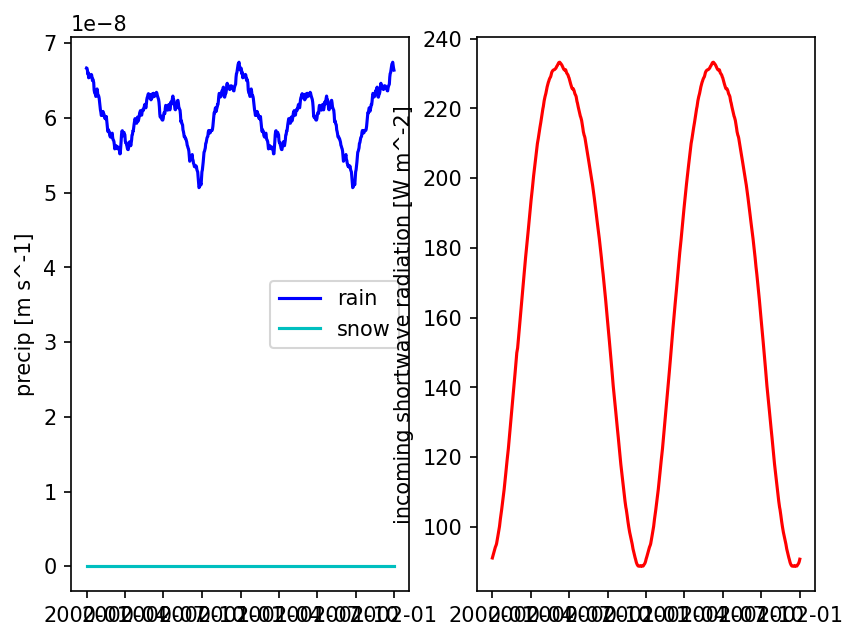

In [15]:
# plot the smoothed precip result
fig = plt.figure()
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data_smooth_ats.times])
prain = met_data_smooth_ats['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data_smooth_ats['precipitation snow [m SWE s^-1]'].data[:,5,5]
ax.plot(times, prain, 'b', label='rain')
ax.plot(times, psnow, 'c', label='snow')

ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data_smooth_ats['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times, qswin, 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
plt.show()

In [16]:
# often smoothing precip like that is a bad idea -- you now have every day misting with low intensity rain which can result in a ton of interception
# and canopy evaporation and no transpiration.  Another approach is to just take the median total rainfall year and repeat that year multiple times.
precip_raw = met_data_warped['prcp'].data
shape_xy = precip_raw.shape[1:]
precip_raw = precip_raw.reshape((-1, 365,)+shape_xy)
annual_precip_raw = precip_raw.sum(axis=(1,2,3))

# note -- don't use np.median here... for even number of years it will not appear.  Instead, sort and talk the halfway point
median_i = sorted(((i,v) for (i,v) in enumerate(annual_precip_raw)), key=lambda x : x[1])[len(annual_precip_raw)//2][0]
typical_precip_raw = np.tile(precip_raw[median_i], (2,1,1))
met_data_smooth['prcp'] = typical_precip_raw

# convert that to ATS
met_data_smooth_ats = watershed_workflow.daymet.convertToATS(met_data_smooth)

# write to disk
filename = os.path.join('Coweeta', 'output_data', 'watershed_daymet-ats_typical.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_smooth_ats,
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))
    

2024-05-06 22:18:01,723 - root - INFO: Converting to ATS met input
2024-05-06 22:18:01,730 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-ats_typical.h5


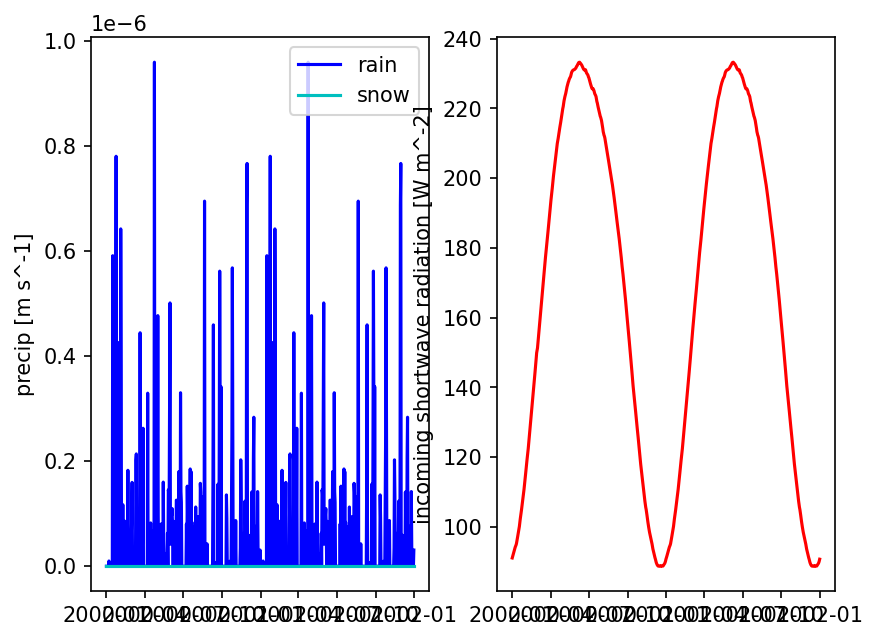

In [17]:
# plot again, different precip typical year
fig = plt.figure()
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data_smooth_ats.times])
prain = met_data_smooth_ats['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data_smooth_ats['precipitation snow [m SWE s^-1]'].data[:,5,5]
ax.plot(times, prain, 'b', label='rain')
ax.plot(times, psnow, 'c', label='snow')

ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data_smooth_ats['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times, qswin, 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
plt.show()